<a href="https://colab.research.google.com/github/dtabuena/Workshop/blob/main/Image/PyShuTu_3Vec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# !pip install opencv-python
import os
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import cv2
import skimage as ski
from tqdm import tqdm
import scipy as sci

In [2]:
# (x,y,z) = (695,435,63)
# fig,ax =plot_point_data(x,y,z,image_stack,rad=250,lw=.5)

In [3]:
""" Helper Plotting"""
def plot_point_data(x,y,z,image_stack,vmin=None,vmax=None,lw=.2,figsize=(3,2.7),cmap='gray',rad=None):
    # () = xyz

    if rad is not None:
        min_x = np.max([x-rad,0])
        max_x = np.min([x+rad,image_stack.shape[0]])
        min_y = np.max([y-rad,0])
        max_y = np.min([y+rad,image_stack.shape[1]])
        image_stack = image_stack[min_y:max_y,min_x:max_x,:]
        x=rad
        y=rad

    fig,ax=plt.subplots(2,2,width_ratios=[5, 1],height_ratios=(5,1),figsize=figsize,dpi=300)
    ax[1,1].axis('off')

    ax[0,0].imshow(image_stack[:,:,z],aspect='auto',vmin=vmin,vmax=vmax,cmap=cmap,zorder=-1)
    ax[0,0].axvline(x,color='m',linewidth=lw)
    ax[0,0].axhline(y,color='c',linewidth=lw)

    collapse_x = image_stack[y,:,:].T
    ax[1,0].imshow(collapse_x,aspect='auto',vmin=vmin,vmax=vmax,cmap=cmap,zorder=-1)
    ax[1,0].axhline(z,color='y',linewidth=lw)
    ax[1,0].axvline(x,color='m',linewidth=lw)

    collapse_y =image_stack[:,x,:]
    print(collapse_y.shape)
    ax[0,1].imshow(collapse_y,aspect='auto',vmin=vmin,vmax=vmax,cmap=cmap,zorder=-1)
    ax[0,1].axvline(z,color='y',linewidth=lw)
    ax[0,1].axhline(y,color='c',linewidth=lw)

    return fig,ax

def uint8_invert(image):
    return ((-1*(image.astype(float)-127.5)) + 127.5).astype("uint8")

In [4]:
""" Load Pilot Image"""
image_set_dir = "C:\\Users\\dennis.tabuena\\Dropbox (Gladstone)\\0_Projects\\_Hyper+Crisper\\Morphological_Analysis\\CA1\\"
image_tag = 'Overlay'
os.chdir(image_set_dir)
tif_list=list()
for dir,root,files in os.walk(image_set_dir):
    for f in files:
        if image_tag in f:
            tif_list.append(os.path.join(dir,f))
pd_dict = {'file_loc': [t for t in tif_list],
           'z': [t.split("_")[-2] for t in tif_list]}
image_df = pd.DataFrame(pd_dict)
"""Build Stack"""
image_stack = list()
for path in tqdm( image_df['file_loc'] ):
    image_data =cv2.imread(path)
    image_data = image_data[:,:,1]
    image_stack.append(image_data)
image_stack=np.stack(image_stack,axis=-1)
# print(image_stack.shape)


100%|████████████████████████████████████████████████████████████████████████████████| 172/172 [00:10<00:00, 16.86it/s]


In [5]:
def build_filter_vec_set(filter_params,top=np.pi):
    """ build a list of filters at different angles (thetas) """
    theta_list = np.arange(0,1,1/filter_params['n_kernel']) * top
    filter_list = list()
    for theta in theta_list:
        filter = -np.real(ski.filters.gabor_kernel(filter_params['spatial_freq'],
                                                    theta,
                                                    sigma_x=filter_params['radius'],
                                                    sigma_y=filter_params['len'],
                                                    n_stds=filter_params['n_stdevs'],))
        filter_list.append(filter)
    filter_list = normalize_filters(filter_list)
    filter_list = square_filters(filter_list)
    vectors = rad_2_vec(theta_list)
    filter_set = {'filter_list':filter_list,'vectors':vectors}
    return filter_set

def square_filters(filter_list):
    """ pad all filters to squares of the same size"""
    dims = np.array([f.shape for f in filter_list])
    max_d =  np.max(dims)
    for i,filter in enumerate(filter_list):
        f_dim = filter.shape
        delta = max_d-f_dim
        half_delta = (delta/2).astype(int)
        padded= np.pad(filter,((half_delta[0],half_delta[0]),
                               (half_delta[1],half_delta[1]),))
        filter_list[i] = padded
    return filter_list

def normalize_filters(filter_list):
    """ scale filters to maximum (0:1) """
    dims = np.array([(np.min(x),np.max(x)) for x in filter_list])
    scalar = 1 / np.max(np.abs(dims))
    filter_list = [x*scalar for x in filter_list]
    return filter_list

def rad_2_vec(angles):
    return [{'x':np.cos(a),'y':np.sin(a)} for a in angles]

def even_axs(n):
    rt_n = np.sqrt(n)
    y=int(np.floor(rt_n))
    x = int(np.ceil(n/y))
    return (x,y)





# (fx,fy) = even_axs(filter_params['n_kernel'])
# fig, ax = plt.subplots(fy,fx,figsize=(fx,fy),dpi=100)
# ax = ax.flatten()
# for i,f in enumerate(filter_set['filter_list']):
#     cbh = ax[i].imshow(f,cmap='coolwarm',vmin=-1,vmax=1)
#     plt.colorbar(cbh)
#     title_str = str(np.round(filter_set['vectors'][i]['x'],2)) +' : '+ \
#                 str(np.round(filter_set['vectors'][i]['y'],2))
#     ax[i].set_title(title_str)
#     ax[i].set_xticks([])
#     ax[i].set_yticks([])
# plt.tight_layout()

In [6]:
sample_stack = image_stack[490:960,860:1440]

In [7]:
def min_project(image_stack,dim=2):
    projection = np.min(image_stack.astype('float16'),dim).astype(float)
    projection = (projection - np.min(projection)) / (np.max(projection) - np.min(projection))
    return projection

def background_sub(image,sigma):
    background = sci.ndimage.gaussian_filter(image,sigma=sigma)
    # fig,ax=plt.subplots(1,2,figsize=(2,1),dpi=300)
    # ax[0].imshow(background,cmap='gray')
    # ax[0].set_xlim(xlims)
    # ax[0].set_ylim(ylims)
    # ax[0].set_title('background')
    # _=ax[1].hist(image.flatten())
    subtracted = image.astype('float16')-background
    subtracted = (subtracted-np.min(subtracted.flatten())) / (np.max(subtracted.flatten()) - np.min(subtracted.flatten()))
    return subtracted


# # print(image_stack.shape)

# projection = min_project(sample_stack)
# fig,ax=plt.subplots(1,2,figsize=(2,1),dpi=300)
# ax[0].imshow(projection,cmap='gray')
# ax[0].set_title('proj')
# _=ax[1].hist(projection.flatten())





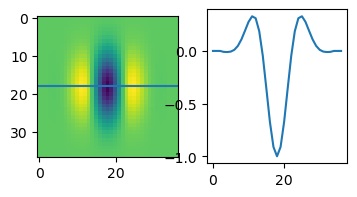

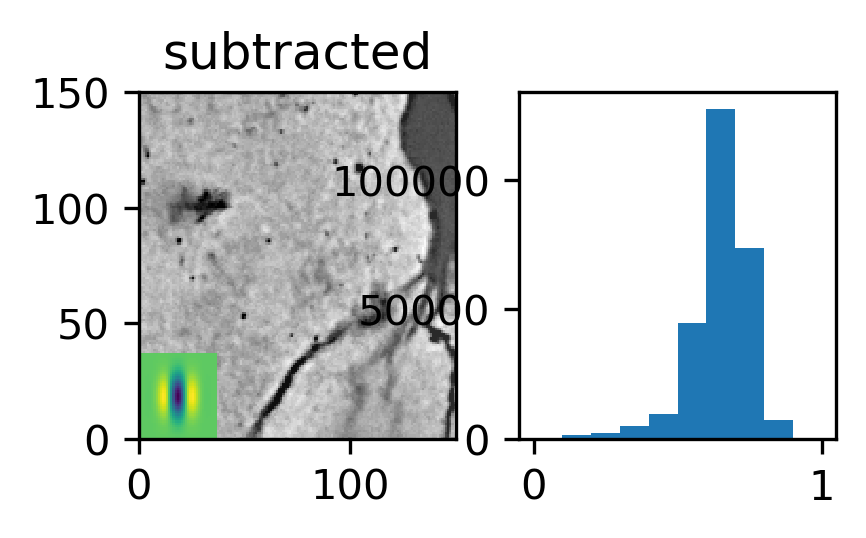

In [8]:

rad = 5
filter_params = {'radius': rad, 'len': 6, 'n_kernel': 7,
                 'spatial_freq': .1/rad*3 , 'n_stdevs': 3}


filter_set = build_filter_vec_set(filter_params)
filter = filter_set['filter_list'][0]

fig,ax=plt.subplots(1,2,figsize=(4,2),dpi=100)
half_dim = int(filter.shape[0]/2)
cbh = ax[0].imshow(filter)
ax[0].axhline(half_dim)
ax[1].plot(filter[half_dim,:])

subtracted = background_sub(sample_stack[:,:,50],sigma=32)
fig,ax=plt.subplots(1,2,figsize=(3,1.5),dpi=300)
ax[0].pcolormesh(subtracted[150:300,150:300],cmap='gray')
ax[0].set_title('subtracted')
_=ax[1].hist(subtracted.flatten())
ax[0].pcolormesh(filter)


In [9]:
def convolve_plane(image_plane,filter_set):
    conv_list = list()
    for filter in filter_set['filter_list']:
        filter_result = sci.signal.convolve2d(image_plane,
                                              filter,
                                              mode='same',
                                              boundary='symm')
        conv_list.append(filter_result)
    filter_results = np.stack(conv_list,axis=-1)
    return filter_results


def convolve_zstack(image_stack,filter_set):
    num_z = image_stack.shape[2]
    stack_conve_results = np.zeros( image_stack.shape + (len(filter_set['filter_list']),) ,'float16')
    for zi in tqdm( range(image_stack.shape[-1]) ):
        filter_results = convolve_plane(image_stack[:,:,zi], filter_set)
        stack_conve_results[:,:,zi,:] = filter_results
    return stack_conve_results

    # z_list = [image_stack[:,:,z] for z in range(image_stack.shape[-1])]
    # for z_plane in tqdm( z_list ):
    #     filter_results = convolve_plane(z_plane,filter_set)
    #     stack_conv_list.append(filter_results)
    # full_filter_results=np.stack(stack_conv_list,axis=-1)
    # return full_filter_results



conv_results = convolve_zstack(sample_stack,filter_set)
conv_results.shape


100%|████████████████████████████████████████████████████████████████████████████████| 172/172 [17:26<00:00,  6.08s/it]


(470, 580, 172, 7)

In [10]:
def norm_01(data):
    return (data-np.min(data)) / (np.max(data)-np.min(data))


In [85]:
def conv_to_mask(conv_results,orig,thresh,to_plot=False):
    conv_results = sci.stats.zscore(norm_01(conv_results))
    max_ind = np.argmax(conv_results,axis=-1)
    max_response = np.max(conv_results,axis=-1)
    min_ind = np.argmin(conv_results,axis=-1)
    min_response = np.min(conv_results,axis=-1)
    delta = max_response - min_response

    max_mask= max_response>thresh['max']
    delta_mask = delta>thresh['d']

    mask = np.logical_and(delta_mask,max_mask)



    if to_plot:
        fig,ax=plt.subplots(2,4,figsize=(8,4),dpi=200)
        ax = ax.flatten()

        ax[0].imshow(orig,cmap='gray')
        ax[0].set_title('original')

        cbh1 = ax[1].imshow(max_response,cmap='afmhot')
        ax[1].set_title('max_filter_response')
        plt.colorbar(cbh1)

        cbh2 = ax[2].imshow(delta,cmap='afmhot')
        ax[2].set_title('delta')
        plt.colorbar(cbh2)


        cbh3 = ax[3].imshow(min_response,cmap='afmhot')
        ax[3].set_title('min_response')
        plt.colorbar(cbh3)

        (d1,d2) = (115,225)
        (d3,d4) = (115,215)
        (d5,d6) = (95,145)
        for a in ax[0:6]:
            a.scatter(d3,d4,s=.1,color='pink')
            a.scatter(d1,d2,s=.1,color='c')
            a.scatter(d5,d6,s=.1,color='red')
        ax[7].set_title('filter phase')
        ax[7].plot(conv_results[d2,d1,:],color='c')
        ax[7].plot(conv_results[d4,d3,:],color='pink')
        ax[7].plot(conv_results[d6,d5,:],color='orange')


        ax[5].imshow(max_mask)
        ax[5].set_title('max_mask')


        ax[6].imshow(delta_mask)
        ax[6].set_title('delta_mask')

        ax[4].imshow(mask)
        ax[4].set_title('mask')

        plt.tight_layout()
    return mask




    # ax[5].hist2d(max_response.flatten(),delta.flatten(),bins=40)
    # ax[5].set_ylabel('delta')
    # ax[5].set_xlabel('max')





    # fig,ax = plt.subplots(1)



mask = conv_to_mask(conv_results,sample_stack,thresh={'d':1,'max':2})


# conv_to_mask(conv_results[:,:,50,:],sample_stack[:,:,50],thresh={'d':1,'max':2})
# conv_to_mask(conv_results[100:400,200:400,50,:],sample_stack[100:400,200:400,50],thresh={'d':1.5,'max':1})

In [92]:
mask.shape

(470, 580, 172)

In [94]:
import tifffile
tifffile.imwrite('./CONV_mask.tiff', mask.transpose([2,0,1]))

In [ ]:


def convolve_filter_plane(image,filter_set):
    """ apply fitlers to a 2d image, return power(x,y,filter)"""
    result_list=list()
    for theta,filter in zip(filter_set['theta_list'],filter_set['filter_list']):
        result = sci.signal.convolve2d(image, filter, mode='same',boundary='symm')
        result_list.append(result)
    image_result = np.stack(result_list,axis=-1)
    return image_result


def convolve_filters(image_stack,filter_set):
    """ Apply filters to each Plane itteratively, return results as power(x,y,z,filter)"""
    stack_conv_result=list()
    z_depth = image_stack.shape[2]
    for z in range(z_depth):
        image_result = convolve_filter_plane(image_stack[:,:,z],filter_set)
        stack_conv_result.append(image_result)
    stack_conv_result = np.stack(stack_conv_result,axis=-2)
    return stack_conv_result

2.8284271247461903


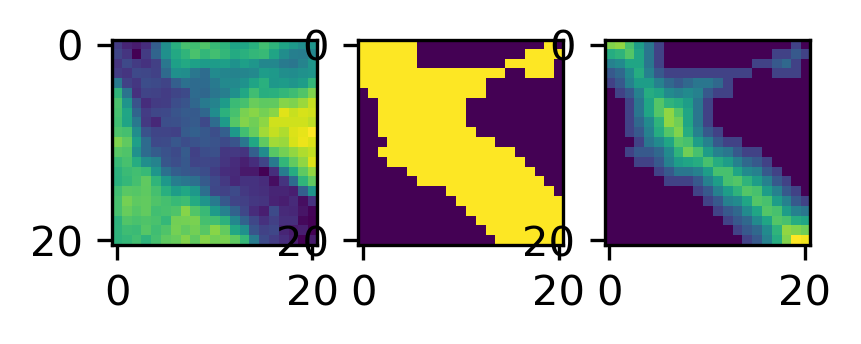

In [ ]:
def get_local_image(point,locality_px,full_stack):
    """ Return local stack values centered on a point"""
    local_x = np.arange(point[0]-locality_px[0],point[0]+locality_px[0]+1).astype(int)
    local_y = np.arange(point[1]-locality_px[1],point[1]+locality_px[1]+1).astype(int)
    local_z = np.arange(point[2]-locality_px[2],point[2]+locality_px[2]+1).astype(int)
    local_image = full_stack[:,local_x,:]
    local_image = local_image[local_y,:,:]
    local_image = local_image[:,:,local_z]

    # """plotting for debug"""
    # fig,ax=plt.subplots(1,1,figsize=(1,1),dpi=300)
    # ax.imshow(local_image[:,:,2])

    return local_image


def get_radius(point,full_stack,locality_px = (10,10,5) ):
    """ Return Radius of Branch centered on point"""
    local_image = get_local_image(point,locality_px,full_stack)
    threshold = ski.filters.threshold_otsu(local_image)
    local_binary = local_image<threshold*1.1
    distance = sci.ndimage.distance_transform_edt(local_binary)
    radius = distance[locality_px]

    """plotting for debug"""
    fig,ax=plt.subplots(1,3,figsize=(3,9),dpi=300)
    ax[0].imshow(local_image[:,:,2])
    ax[1].imshow(local_binary[:,:,2])
    ax[2].imshow(distance[:,:,2],interpolation=None)
    print(distance[locality_px])

    return radius






2.8284271247461903
[(4.0, -0.0), (5.0, 1.0), (-0.0, -4.0), (-0.0, 5.0), (2.0, 2.0), (-4.0, 1.0), (-2.0, -2.0), (4.0, 2.0), (2.0, -5.0), (2.0, 4.0), (-4.0, 3.0), (-3.0, 1.0), (2.0, -3.0), (-4.0, -4.0), (-2.0, 2.0), (3.0, 1.0), (5.0, -2.0), (5.0, -1.0), (-3.0, 3.0), (1.0, 3.0), (-4.0, -2.0), (-1.0, -5.0), (-2.0, -5.0), (-4.0, -1.0), (-2.0, 4.0), (-1.0, 4.0), (3.0, 3.0), (5.0, -0.0), (-3.0, -4.0), (-0.0, -5.0), (1.0, -4.0), (1.0, 5.0), (-4.0, -0.0), (-2.0, -3.0), (-1.0, -3.0), (3.0, -4.0), (5.0, 2.0), (4.0, 4.0), (-5.0, 1.0), (-3.0, -2.0), (-0.0, -3.0), (-3.0, -1.0), (-4.0, 2.0), (3.0, -2.0), (3.0, -1.0), (4.0, -3.0), (-3.0, -0.0), (-4.0, 4.0), (3.0, -0.0), (-3.0, 2.0), (-0.0, 4.0), (-4.0, -3.0), (-2.0, 5.0), (3.0, 2.0), (4.0, 1.0), (-5.0, -2.0), (-5.0, -1.0), (-3.0, 4.0), (1.0, -5.0), (1.0, 4.0), (2.0, 3.0), (-1.0, -4.0), (3.0, 4.0), (4.0, 3.0), (-5.0, -0.0), (-3.0, -3.0), (1.0, -3.0), (2.0, -4.0), (2.0, 5.0), (3.0, -3.0), (4.0, -4.0), (-5.0, 2.0), (2.0, -2.0), (-2.0, 3.0), (-1.0, 3.0), 

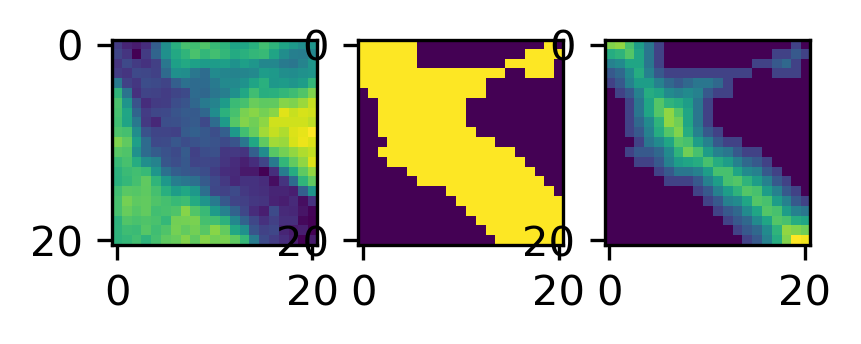

In [ ]:


def convolve_filter_plane(image,filter_set):
    """ apply fitlers to a 2d image, return power(x,y,filter)"""
    result_list=list()
    for theta,filter in zip(filter_set['theta_list'],filter_set['filter_list']):
        result = sci.signal.convolve2d(image, filter, mode='same',boundary='symm')
        result_list.append(result)
    image_result = np.stack(result_list,axis=-1)
    return image_result


def convolve_filters(image_stack,filter_set):
    """ Apply filters to each Plane itteratively, return results as power(x,y,z,filter)"""
    stack_conv_result=list()
    z_depth = image_stack.shape[2]
    for z in range(z_depth):
        image_result = convolve_filter_plane(image_stack[:,:,z],filter_set)
        stack_conv_result.append(image_result)
    stack_conv_result = np.stack(stack_conv_result,axis=-2)
    return stack_conv_result



def cart2pol(X, Y):
    rho = np.sqrt(X**2 + Y**2)
    ang = np.arctan2(Y, X)
    return rho, ang

def pol2cart(rad,ang):
    X = rad*np.cos(ang)
    Y = rad*np.sin(ang)
    return X,Y


def calc_point_vector(point,filter_set,full_stack,locality_px=(10,10,5),):
    """ Take in a point and get the best 2d_vector """
    theta_list = filter_set['theta_list']
    local_image = get_local_image(point,locality_px,full_stack)
    stack_conv_result = convolve_filters(local_image,filter_set)
    theta_matrix = np.ones_like(stack_conv_result)
    for i,theta in enumerate(theta_list):
        theta_matrix[:,:,:,i]=theta

    rho,theta = half_circ_mean(rho_matrix=stack_conv_result,
                                         theta_matrix=theta_matrix)
    anti_theta = theta+np.pi
    return rho,theta,anti_theta


def calc_mean_vector(stack_conv_result,filter_set):
    theta_list = filter_set['theta_list']



def half_circ_mean(rho_matrix,theta_matrix):
    double_theta = theta_matrix*2
    X,Y = pol2cart(rho_matrix, double_theta)
    mean_X = np.mean(X.flatten())
    mean_Y = np.mean(Y.flatten())
    mean_rho, mean_double_theta = cart2pol(mean_X,mean_Y)
    mean_theta = mean_double_theta/2
    if mean_theta<0:
        mean_theta=mean_theta+np.pi

    # """plotting for debug"""
    # fig, ax = plt.subplots(1,2,figsize=(4,2),subplot_kw={'projection': 'polar'},dpi=100)
    # ax[0].scatter(theta_matrix, rho_matrix,s=.1,color='gray')
    # ax[0].scatter(mean_theta, mean_rho,color='m')
    # ax[0].set_title('Half')

    # ax[1].scatter(double_theta, rho_matrix,s=.1,color='gray')
    # ax[1].scatter(mean_double_theta, mean_rho,color='m')
    # ax[1].set_title('Full')

    return mean_rho,mean_theta



def get_candidates(point,seg_radius,scalar=1.5,variance=.3):
    min_rho = radius*scalar - radius*variance
    max_rho = radius*scalar + radius*variance
    # print('min_rho',min_rho)
    # print('max_rho',max_rho)
    mesh_range = np.arange(-max_rho,max_rho,.1)
    X,Y = np.meshgrid(mesh_range,mesh_range)
    X = X.flatten()
    Y = Y.flatten()
    Z = np.sqrt( X**2 + Y**2 )
    Z_ok = np.logical_and(Z>min_rho,Z<max_rho)
    Z_ok_ind = np.where(Z_ok)[0]
    X_ok = np.round(X[Z_ok_ind])
    Y_ok = np.round(Y[Z_ok_ind])
    coord_list = [(x,y) for x,y in zip(X_ok,Y_ok)]
    coord_list = list(set(coord_list))
    return coord_list






radius = get_radius(point,image_stack)
coord_list = get_candidates(point,radius)
print(coord_list)

In [ ]:

filter_params = {'rad': 3,
                 'len': 4,
                 'n_kernel': 12,
                 'frequency': .1,
                 'n_stds': 3,
                 }

filter_set = build_filter_set(filter_params)
_,theta,anti_theta = calc_point_vector(point,filter_set,image_stack,locality_px=(10,10,3))
print(theta)

2.3561944901923457


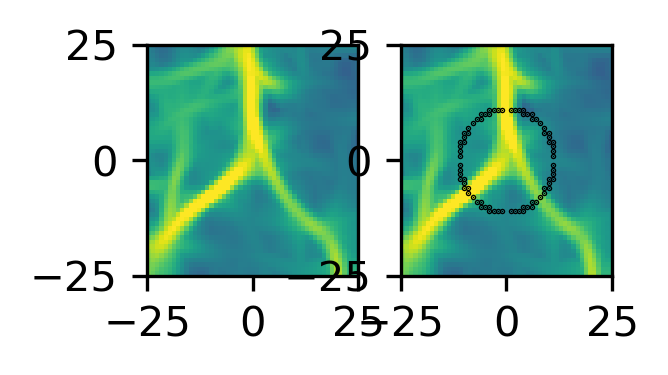

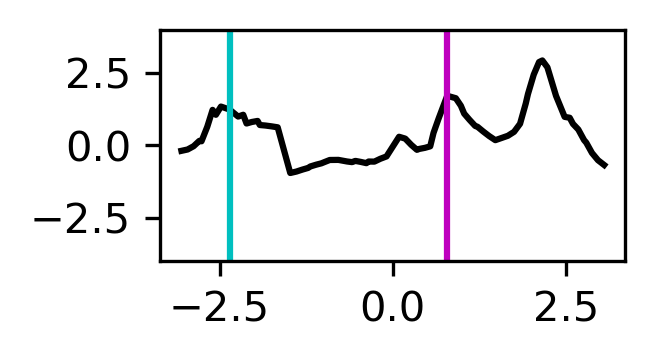

In [ ]:
def neg_pi_to_pi(angles):
    angles = np.mod(angles+np.pi,2*np.pi)-np.pi
    return angles

def get_candidate_metrics(coord_list,prev_point,prev_point_theta,full_stack,filter_set):
    prev_point_theta = prev_point_theta-np.pi/2
    rel_x_indicies = np.array([coord[0] for coord in coord_list]).astype(int)
    rel_y_indicies = np.array([coord[1] for coord in coord_list]).astype(int)

    local_image = get_local_image(prev_point,(25,25,3),full_stack)
    stack_conv_result = convolve_filters(local_image,filter_set)
    max_project = np.max(stack_conv_result,axis=-1)
    mean_conv = np.mean(stack_conv_result.flatten())
    std_conv = np.std(stack_conv_result.flatten())
    max_project = (max_project - mean_conv) / std_conv

    _, xy_thetas = cart2pol(rel_y_indicies,rel_x_indicies)
    xy_thetas = neg_pi_to_pi(xy_thetas)
    local_x_range = np.arange(local_image.shape[0])
    local_x_range = local_x_range-np.mean(local_x_range)

    local_y_range = np.arange(local_image.shape[1])
    local_y_range = -(local_y_range-np.mean(local_y_range))

    new_order = np.argsort(xy_thetas)
    rel_x_indicies = rel_x_indicies[new_order]
    rel_y_indicies = rel_y_indicies[new_order]
    xy_thetas = xy_thetas[new_order]

    # x_indicies = rel_x_indicies+origin[0]
    # y_indicies = rel_y_indicies+origin[1]


    intensity = max_project[rel_x_indicies,rel_y_indicies,0]


    fig,ax=plt.subplots(1,2,figsize=(2,1),dpi=300)
    cmbh = ax[0].pcolorfast(local_y_range,local_x_range,max_project[:,:,0],vmin=-3,vmax=3)
    cmbh = ax[1].pcolorfast(local_y_range,local_x_range,max_project[:,:,0],vmin=-3,vmax=3)
    ax[1].scatter(rel_x_indicies,rel_y_indicies,s=.1,color='k')

    fig,ax=plt.subplots(1,1,figsize=(2,1),dpi=300)
    ax.plot(xy_thetas,intensity,'k')
    # ax.plot(xy_thetas+2*np.pi,intensity,'k')
    # ax.plot(xy_thetas-2*np.pi,intensity,'k')
    ax.axvline(prev_point_theta,color='m')
    ax.axvline(prev_point_theta-np.pi,color='c')
    ax.set_ylim((-4,4))


    return intensity, xy_thetas, rel_x_indicies, rel_y_indicies


point = (737,480,63)
rho,theta,anti_theta = calc_point_vector(point,filter_set,image_stack)
coord_list = get_candidates(point,radius,scalar=4,variance=.01)
intensity, xy_thetas, rel_x_indicies, rel_y_indicies = get_candidate_metrics(coord_list,point,theta,image_stack,filter_set)




#     return None




In [ ]:
# (x,y,z) = point
# fig,ax =plot_point_data(x,y,z,image_stack,rad=250,lw=.5)

In [ ]:


def select_new_points(intensity,xy_thetas,rel_x_indicies,rel_y_indicies,point,theta,threshold = 1,delta_theta=np.pi/4):

    distance = np.pi/8 / np.mean(np.diff(xy_thetas))

    good_intensity = intensity*(intensity>threshold)

    peaks, _ = sci.signal.find_peaks(good_intensity,distance=5)

    # fig,ax=plt.subplots(figsize=(6,1))
    # extended_xy_thetas = np.concatenate([xy_thetas-(2*np.pi),xy_thetas,xy_thetas+(2*np.pi)],axis=0)
    # extended_intensity = np.concatenate([intensity,intensity,intensity],axis=0)
    # ax.plot(extended_xy_thetas,extended_intensity,'k')
    # ax.plot(xy_thetas,good_intensity,'r')
    # ax.scatter(xy_thetas[peaks],good_intensity[peaks],color='r')

    new_points = [ (rel_x_indicies[p], rel_y_indicies[p]) for p in peaks  ]
    return new_points



new_points = select_new_points(intensity,xy_thetas,rel_x_indicies,rel_y_indicies,point,theta,threshold = 1)

print(new_points)

[(-7, -9), (8, 8), (9, -6)]
